In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras 
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

## Task 3

In [4]:
# Load data
dfTrainData = pd.read_csv("./../TrainData.csv")
dfSolution = pd.read_csv("./../Solution.csv")
dfWFI = pd.read_csv("./../WeatherForecastInput.csv")

dfTrainData

,TIMESTAMP,POWER,U10,V10,WS10,U100,V100,WS100
0,20120101 1:00,0.273678,0.534894,-3.660243,3.699120,0.765355,-4.486657,4.551468
1,20120101 2:00,0.086796,0.330813,-2.676430,2.696797,0.469875,-3.213752,3.247920
2,20120101 3:00,0.006811,-0.065839,-2.029072,2.030140,-0.020893,-2.418119,2.418209
3,20120101 4:00,0.018646,-0.419549,-1.799090,1.847362,-0.444867,-2.149654,2.195203
4,20120101 5:00,0.034812,-0.754224,-1.661526,1.824698,-0.838274,-1.991829,2.161038
...,...,...,...,...,...,...,...,...
16075,20131031 20:00,0.101254,-1.459917,-1.778960,2.301316,-1.974368,-4.936280,5.316483
16076,20131031 21:00,0.105047,-1.293326,-2.350447,2.682777,-0.781394,-4.903565,4.965433
16077,20131031 22:00,0.145079,-0.308284,-2.441885,2.461269,0.257905,-4.027432,4.035681
16078,20131031 23:00,0.180933,1.148765,-2.789011,3.016330,1.628004,-3.520358,3.878572


In [5]:
# Limit use of wind speed at 10m above ground level

# TrainData
dfTrainData = dfTrainData.drop(columns=['U100', 'V100', 'WS100'])

# WeatherForecastInput
dfWFI = dfWFI.drop(columns=['U100', 'V100', 'WS100'])
dfWFI

,TIMESTAMP,U10,V10,WS10
0,20131101 1:00,3.462251,-1.066374,3.622753
1,20131101 2:00,3.651341,-0.337717,3.666925
2,20131101 3:00,3.657829,0.328049,3.672510
3,20131101 4:00,3.551698,0.735371,3.627028
4,20131101 5:00,3.586921,1.050811,3.737673
...,...,...,...,...
715,20131130 20:00,-2.527419,-6.623859,7.089666
716,20131130 21:00,-2.529020,-7.423845,7.842794
717,20131130 22:00,-3.105103,-6.653005,7.341943
718,20131130 23:00,-2.286417,-6.165074,6.575396


In [6]:
# Make wind power production forecasting when we only have wind power generation data; and we do not have other data

# The following columns should be removed: U10, V10, WS10, U100, V100, WS100
# In the new training data file, we only have two columns: TIMESTAMP and POWER, which is called as time-series data
dfTrainData = dfTrainData.drop(columns=['U10', 'V10', 'WS10'])

In [7]:
# Convert TIMESTAMP to ORDINAL_DATE and TIME

# converting dfTrainData
date = []
time = []
for index, row in dfTrainData.iterrows():
    format = datetime.strptime(row['TIMESTAMP'],  "%Y%m%d %H:%M")
    # convert date to ordinal
    date.append(format.toordinal())    
    time.append(format.hour)
dfTrainData['ORDINAL_DATE'] = date
dfTrainData['TIME'] = time

# converting dfWeatherForecastInput
date = []
time = []
for index, row in dfWFI.iterrows():
    format = datetime.strptime(row['TIMESTAMP'],  "%Y%m%d %H:%M")
    # convert date to ordinal
    date.append(format.toordinal())   
    time.append(format.hour)
dfWFI['ORDINAL_DATE'] = date
dfWFI['TIME'] = time

# Separate features and target variable
X_train = dfTrainData[['ORDINAL_DATE', 'TIME']]
y_train = dfTrainData['POWER']

# Predict the wind power production for the whole month 11.2013 based on the MLR model and weather data in WeatherForecastInput.csv
X_test = dfWFI[['ORDINAL_DATE', 'TIME']]

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Root mean squared error (RMSE): 0.3001273628880958


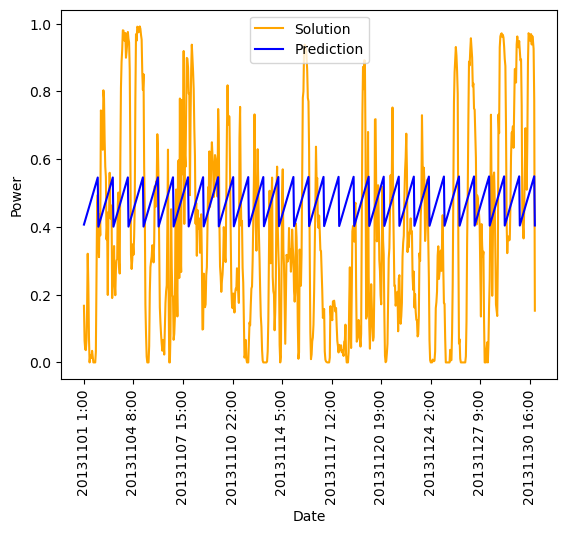

In [8]:
""" Linear Regression """
# Train the linear regression model
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

# Prediction
LR_y_pred = LR_model.predict(X_test)

# Evaluate the model
print('Root mean squared error (RMSE):', np.sqrt(mean_squared_error(dfSolution['POWER'], LR_y_pred)))

# Plotting
plt.figure()
plt.plot(dfWFI['TIMESTAMP'], dfSolution['POWER'], label='Solution', color='orange')
plt.plot(dfWFI['TIMESTAMP'], LR_y_pred, label='Prediction', color='b')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(dfWFI['TIMESTAMP'][::79],  rotation='vertical')
plt.legend()
plt.show()

In [9]:
""" Supported Vector Regression """
# Train the SVR model
SVRlinear_model = SVR(kernel='linear', gamma='scale', C=1.0, epsilon=0.1)
SVRlinear_model.fit(X_train, y_train)

SVRrbf_model = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.1)
SVRrbf_model.fit(X_train, y_train)

SVRpoly_model = SVR(kernel='poly', gamma='scale', C=1.0, epsilon=0.1)
SVRpoly_model.fit(X_train, y_train)

# Prediction
SVRlinear_y_pred = SVRlinear_model.predict(X_test)
SVRrbf_y_pred = SVRrbf_model.predict(X_test)
SVRpoly_y_pred = SVRpoly_model.predict(X_test)

# Evaluate the model
print('RMSE for linear SVM:', np.sqrt(mean_squared_error(dfSolution['POWER'], SVRlinear_y_pred)))
print('RMSE for rbf SVM:', np.sqrt(mean_squared_error(dfSolution['POWER'], SVRrbf_y_pred)))
print('RMSE for poly SVM:', np.sqrt(mean_squared_error(dfSolution['POWER'], SVRpoly_y_pred)))

RMSE for linear SVM: 0.29041860928307206
RMSE for rbf SVM: 0.28648036813069555
RMSE for poly SVM: 0.3210373948210141


Root mean squared error (RMSE): 0.34820119654255693


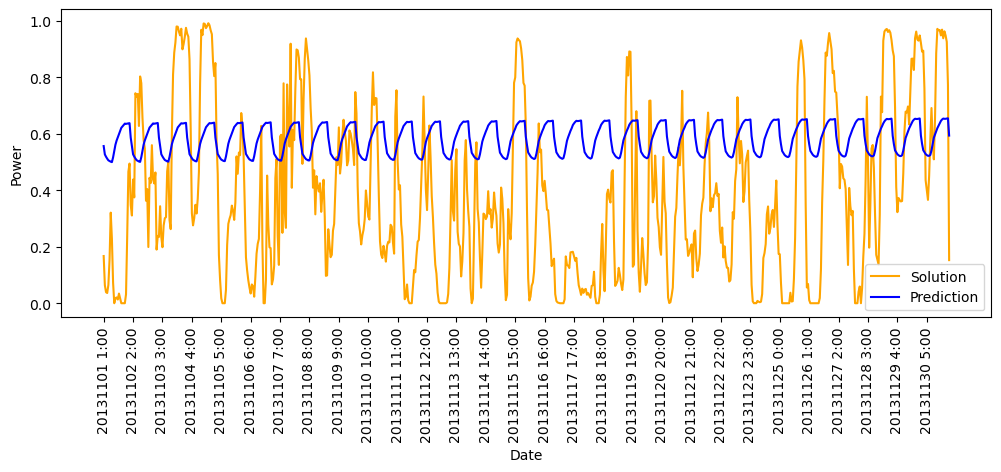

In [10]:
""" Artificial Neural Networks (ANN) """
# Train the ANN model
ANN_model = MLPRegressor(hidden_layer_sizes=(32,32), max_iter=10000, activation='relu', random_state=42)
ANN_model.fit(X_train, y_train)

# Prediction
ANN_y_pred = ANN_model .predict(X_test)

# Evaluate the model
print('Root mean squared error (RMSE):', np.sqrt(mean_squared_error(dfSolution['POWER'], ANN_y_pred)))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(dfWFI['TIMESTAMP'], dfSolution['POWER'], label='Solution', color='orange')
plt.plot(dfWFI['TIMESTAMP'], ANN_y_pred, label='Prediction', color='b')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(dfWFI['TIMESTAMP'][::25],  rotation='vertical')
plt.legend()
plt.show()

In [ ]:
""" Artificial Neural Networks (ANN) """

simple_rnn = Sequential(
        [ #Setting up the layers
            SimpleRNN(20, activation='relu', input_shape=(WINDOW_SIZE, 1)), #RNN layer
            Dense(1), #output layer
        ]

    )

    simple_rnn.compile(
        optimizer='adam', 
        loss='mean_squared_error',
    )

    #Reshape the data
    train_X = train_X.values.reshape(-1, WINDOW_SIZE, 1)
    
    history = simple_rnn.fit(
        train_X, train_Y,
        epochs=50, 
        batch_size=30, 
    )

    predictions = simple_rnn.predict(test_X, batch_size=1)
    rmse_RNN = np.sqrt(mean_squared_error(test_Y, predictions))

In [468]:
# Save in the ForecastTemplate3-LR.csv for the linear regression model
LR_pred_df = pd.DataFrame({'TIMESTAMP': dfWFI['TIMESTAMP'], 'POWER': LR_y_pred})
LR_pred_df.to_csv('./../ForecastTemplate/ForecastTemplate3-LR.csv', index=False)

# Save in the ForecastTemplate3-SVR.csv for the supported vector regression model
SVR_pred_df = pd.DataFrame({'TIMESTAMP': dfWFI['TIMESTAMP'], 'POWER': SVRrbf_y_pred})
SVR_pred_df.to_csv('./../ForecastTemplate/ForecastTemplate3-SVR.csv', index=False)

In [470]:
# Evaluate the prediction accuracy
# Compare the predicted wind power and the true wind power measurements (in the file Solution.csv)
# Use the error metric RMSE to evaluate and compare the prediction accuracy among the machine learning approaches

# Linear regression
print('RMSE for linear regression:', np.sqrt(mean_squared_error(dfSolution['POWER'], LR_y_pred)))

# SVM
print('RMSE for linear SVM:', np.sqrt(mean_squared_error(dfSolution['POWER'], SVRlinear_y_pred)))
print('RMSE for rbf SVM:', np.sqrt(mean_squared_error(dfSolution['POWER'], SVRrbf_y_pred)))
print('RMSE for poly SVM:', np.sqrt(mean_squared_error(dfSolution['POWER'], SVRpoly_y_pred)))

RMSE for linear regression: 0.3001273628880958
RMSE for linear SVM: 0.29041860928307206
RMSE for rbf SVM: 0.28648036813069555
RMSE for poly SVM: 0.3210373948210141
